In [1]:
split_selection = 'test' # 'train' or 'val' or 'test'

In [ ]:
from torchvision.datasets import WIDERFace
from torchvision import transforms
import torchvision.transforms.functional as trF
import torch.nn.functional as nnF
import os
import random as rd

# Set paths and other constants
dataset_path = '/itet-stor/hfontaine/net_scratch/datasets'

if not os.path.exists(os.path.join(dataset_path, 'PreprocessedWider')):
    os.makedirs(os.path.join(dataset_path, 'PreprocessedWider'))
if not os.path.exists(os.path.join(dataset_path, 'PreprocessedWider', split_selection)):
    os.makedirs(os.path.join(dataset_path, 'PreprocessedWider', split_selection))
# else : #stop execution if the folder already exists
#     print('Folder already exists')
#     exit()
    

IMAGE_WIDTH_CROP = 500
IMAGE_HEIGHT_CROP = 500
IMAGE_WIDHT_RESIZE = 64
IMAGE_HEIGHT_RESIZE = 64
NORMALIZED_MEAN = [0.485, 0.456, 0.406]
NORMALIZED_STD = [0.229, 0.224, 0.225]

dataset = WIDERFace(root=dataset_path, split=split_selection, download=True)
face_count = 0

for i in range(len(dataset)):
    image, target = dataset[i]
    image = transforms.ToTensor()(image)
    im_height, im_width = image.size()[1:]

    # Pad image if smaller than required size
    padl = padr = padt = padb = 0
    if im_width < IMAGE_WIDTH_CROP:
        padl = (IMAGE_WIDTH_CROP - im_width) // 2
        padr = IMAGE_WIDTH_CROP - im_width - padl
        image = nnF.pad(image, (padl, padr), mode='constant', value=0)
        im_height, im_width = image.size()[1:]
    if im_height < IMAGE_HEIGHT_CROP:
        padt = (IMAGE_HEIGHT_CROP - im_height) // 2
        padb = IMAGE_HEIGHT_CROP - im_height - padt
        image = nnF.pad(image, (0, 0, padt, padb), mode='constant', value=0)
        im_height, im_width = image.size()[1:]
    
    # Crop image at random location
    crop_x = rd.randint(0, im_width - IMAGE_WIDTH_CROP)
    crop_y = rd.randint(0, im_height - IMAGE_HEIGHT_CROP)
    image = trF.crop(image, crop_y, crop_x, IMAGE_HEIGHT_CROP, IMAGE_WIDTH_CROP)
    image = trF.resize(image, (IMAGE_HEIGHT_RESIZE, IMAGE_WIDHT_RESIZE))
    image = transforms.ToPILImage(mode='RGB')(image)

    # Transform bounding boxes
    is_face = 'X'
    if split_selection != 'test':
        is_face = 0
        for j in range(len(target['bbox'])):
            x, y, w, h = target['bbox'][j]
            x = int(x) + padl
            y = int(y) + padt
            w = int(w)
            h = int(h)
            if x >= crop_x + IMAGE_WIDTH_CROP or y >= crop_y + IMAGE_HEIGHT_CROP:
                continue
            if x + w <= crop_x or y + h <= crop_y:
                continue
            x1 = max(crop_x, x)
            w_new = w - (x1 - x)
            y1 = max(crop_y, y)
            h_new = h - (y1 - y)
            if x1 + w_new > crop_x + IMAGE_WIDTH_CROP:
                w_new = crop_x + IMAGE_WIDTH_CROP - x1
            if y1 + h_new > crop_y + IMAGE_HEIGHT_CROP:
                h_new = crop_y + IMAGE_HEIGHT_CROP - y1
            area_new = w_new * h_new
            if area_new * (IMAGE_HEIGHT_RESIZE / IMAGE_HEIGHT_CROP) * (IMAGE_WIDHT_RESIZE / IMAGE_WIDTH_CROP) >= 9 and area_new >= 0.7 * w * h:
                is_face = 1
                face_count += 1
                break
    
    # Save the jpeg image and the is_face label in the name of the file
    image.save(os.path.join(dataset_path, 'PreprocessedWider', split_selection, 'image_' + str(i) + '_' + str(is_face) + '.jpeg'))
    if (i+1) % 100 == 0:
        print('Preprocessing image ' + str(i) + ' of ' + str(len(dataset)))

print('Number of faces: ' + str(face_count))

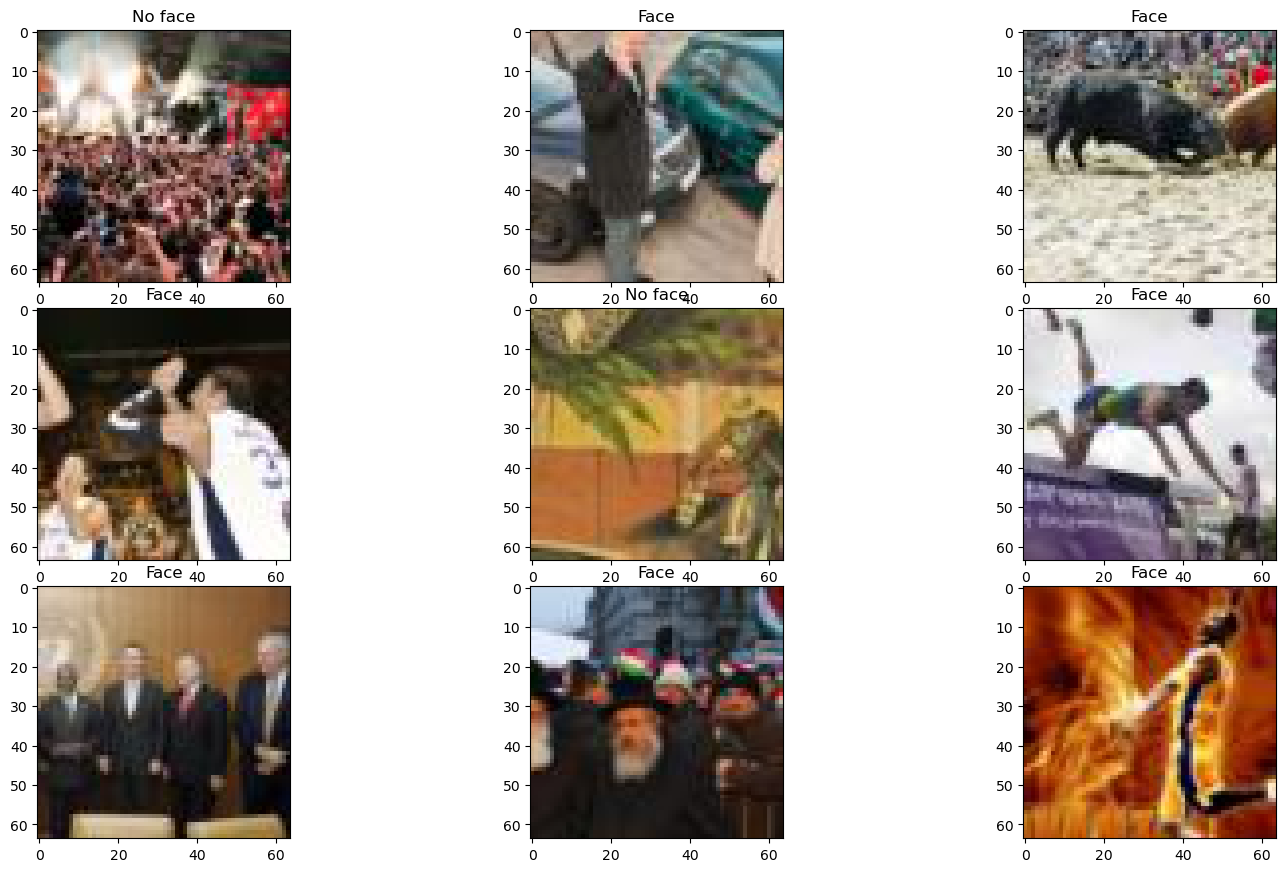

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import torchvision.transforms.functional as trF
import matplotlib.pyplot as plt
import random as rd


IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
NORMALIZED_MEAN = [0.485, 0.456, 0.406]
NORMALIZED_STD = [0.229, 0.224, 0.225]

# Set paths and other constants
dataset_path = '/itet-stor/hfontaine/net_scratch/datasets'
preprocessed_path = os.path.join(dataset_path, 'PreprocessedWider', split_selection)

# Custom dataset class to read preprocessed images
class PreprocessedWiderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpeg')]
    
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load the image and label
        image_name = self.image_files[idx]
        image_path = os.path.join(self.root_dir, image_name)
        image = Image.open(image_path)  # Open image
        image = trF.to_tensor(image)  # Convert image to tensor
        image = trF.normalize(image, NORMALIZED_MEAN, NORMALIZED_STD)  # Normalize image
        # Extract the label from the filename (before the '.jpeg' extension)
        label = int(image_name.split('_')[-1][0])  # 'image_00_1.jpeg' -> label = 1
        if label :
            return image, torch.tensor([1, 0], dtype=torch.float32) #[1, 0] for face
        else:
            return image, torch.tensor([0, 1], dtype=torch.float32) #[0, 1] for no face

# Instantiate the dataset and dataloader
dataset = PreprocessedWiderDataset(root_dir=preprocessed_path)

def unnormalize_image(image, mean, std):
    """
    Reverse the normalization process for a single image.
    Args:
        image (Tensor): Normalized image tensor of shape (C, H, W)
        mean (Tensor): Mean values used during normalization
        std (Tensor): Std values used during normalization
    Returns:
        Tensor: Unnormalized image tensor of shape (C, H, W)
    """
    mean = mean[:, None, None]  # Adjust shape to match (C, H, W)
    std = std[:, None, None]
    return image * std + mean

#show some images in figure with ther bbox
fig = plt.figure(figsize=(18.5, 10.5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i in range(9):
    image, label = dataset[rd.randint(0, len(dataset) - 1)]
    image = unnormalize_image(image, torch.tensor(NORMALIZED_MEAN), torch.tensor(NORMALIZED_STD))
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(image.permute(1, 2, 0))
    ax.title.set_text("Face" if label[0] == 1 else "No face")